# Merge Tuolumne (Gaylor Pit) and GOES datasets

Read in our Gaylor Pit and GOES datasets, set up the time bounds we want to look at, and resample everything to 15 minute intervals.

Then merge the GOES brightness temperature observations with the Gaylor Pit dataset, and output the merged dataset for analysis elsewhere.

In [1]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import xarray as xr
import glob

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    # https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles 

---
#### Open Tuolumne (Gaylor Pit) data files:

In [3]:
tuol_df = pd.read_pickle('data/GaylorPit_Temp_Snowdepth_2017-2020.pkl')
# convert to xarray data array
tuol_ds = tuol_df.to_xarray()

#### Open GOES L1b Radiance observations for the CUES site:
Convert times to UTC-8

In [4]:
# Find all our GOES csv files
directory = '/storage/GOES/pkl/GaylorPit/*.csv'
goes_files = glob.glob(directory)
# Read in the files with pandas
goes = []
_ = [goes.append(pd.read_csv(i)) for i in goes_files]
# concatenate together
goes = pd.concat(goes)
# Change GOES time values from UTC to UTC-8 for CUES site:
goes = goes.rename(columns={'time': 'timeUTC', 'ref_or_tb': 'tb_k'})
goes['time'] = pd.to_datetime(goes.timeUTC)  - pd.Timedelta(hours=8)
goes = goes.drop(columns=['timeUTC'])
# create brightness temperature in C column
goes['tb_c'] = goes.tb_k - 273.15
# Convert pandas dataframe to xarray dataset and and make our local time datetimes the index
_goes = goes.set_index('time')
_goes.sort_index(inplace=True)
goes_ds = _goes.to_xarray()

Find non-orthorectified GOES L1b Radiance observations for comparison:

In [5]:
# Find all our GOES csv files
directory = '/storage/GOES/pkl/GaylorPit_not_orthorectified/*.csv'
goes_files = glob.glob(directory)
# Read in the files with pandas
goes = []
_ = [goes.append(pd.read_csv(i)) for i in goes_files]
# concatenate together
goes = pd.concat(goes)
# Change GOES time values from UTC to UTC-8 for CUES site:
goes = goes.rename(columns={'time': 'timeUTC', 'Rad': 'Rad_not_orthorectified', 'ref_or_tb': 'tb_k_not_orthorectified'})
goes['time'] = pd.to_datetime(goes.timeUTC)  - pd.Timedelta(hours=8)
goes = goes.drop(columns=['timeUTC'])
# create brightness temperature in C column
goes['tb_c_not_orthorectified'] = goes.tb_k_not_orthorectified - 273.15
# Convert pandas dataframe to xarray dataset and and make our local time datetimes the index
_goes = goes.set_index('time')
_goes.sort_index(inplace=True)
goes_not_orthorectified_ds = _goes.to_xarray()

/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


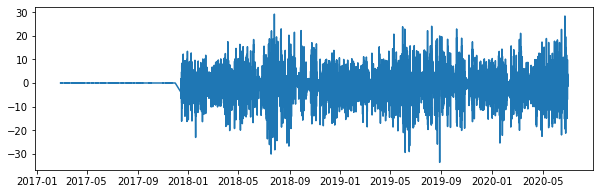

In [6]:
plt.figure(figsize=(10,3))
plt.plot(goes_ds.time, goes_not_orthorectified_ds.tb_c_not_orthorectified - goes_ds.tb_c)

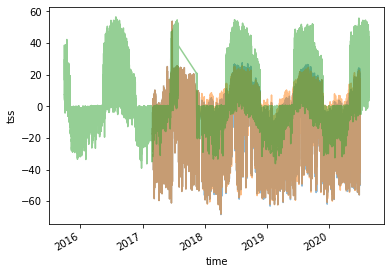

In [7]:
goes_not_orthorectified_ds.tb_c_not_orthorectified.plot(alpha=0.5)
goes_ds.tb_c.plot(alpha=0.5)
tuol_ds.tss.plot(alpha=0.5)

---
#### Set time bounds and resample

Select only the overlapping time period we want, and resample all of these to 15 minute means, ignoring any nan values.

(CUES provides ~1-minute observations, GOES is 5- or 10-minute)

In [8]:
startdate = '2017-03-01'
enddate = '2020-06-30'

tuol_ds_5min = tuol_ds.sel(time=slice(startdate, enddate)).resample(time='15min').reduce(np.nanmean)
goes_ds_5min = goes_ds.sel(time=slice(startdate, enddate)).resample(time='15min').reduce(np.nanmean)
goes_not_orthorectified_ds_5min = goes_not_orthorectified_ds.sel(time=slice(startdate, enddate)).resample(time='15min').reduce(np.nanmean)
#goes_acm_5min = goes_acm.sel(datetime=slice(startdate, enddate)).resample(datetime='5min').reduce(np.nanmean)

/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/xarray/core/variable.py:1462: RuntimeWarning: Mean of empty slice
  data = func(input_data, axis=axis, **kwargs)


#### Merge the datasets

Merge GOES brightness temperature into the Tuolumne Gaylor Pit dataset

In [9]:
# Match the nearest datetimes
_tuol_ds = tuol_ds_5min.sel(time=goes_ds_5min.time)
_goes_ds = goes_ds_5min.sel(time=_tuol_ds.time)
_goes_not_orthorectified_ds = goes_not_orthorectified_ds_5min.sel(time=_tuol_ds.time)

# assign value to new column in tuolumne gaylor pit dataset
_tuol_ds['goes_tb_c'] = (['time'],  _goes_ds.tb_c)
_tuol_ds['goes_rad'] = (['time'],  _goes_ds.Rad)
_tuol_ds['goes_tb_not_orthorectified_c'] = (['time'],  _goes_not_orthorectified_ds.tb_c_not_orthorectified)
_tuol_ds['goes_rad_not_orthorectified'] = (['time'],  _goes_not_orthorectified_ds.Rad_not_orthorectified)

# rename this
tuol_ds_5min = _tuol_ds

**Additional data cleanup steps:**

Compute daily median snow depth:

* **Resample to the daily median snow depth**. 

* There are still a few erroneous large daily snowdepth values, so finally **filter out depths > 400 cm** since those are larger than any other values in the timeseries. 

* Replace all NaN values with linearly interpolated values. 

* Finally add our cleaned up daily median snow depths to the original dataset.

In [10]:
# Compute initial daily median snow depth at Gaylor Pit
daily_median_snow_depth = tuol_ds_5min.depth_cm.resample(time='1D').median()
# remove depths that are larger than the maximum in the whole 2017-2020 data record I've identified (400 cm)
max_daily_median_snowdepth = 400
daily_median_snow_depth = daily_median_snow_depth.where(daily_median_snow_depth<max_daily_median_snowdepth)
# fill nan values by day (I have to go back to a pandas Dataframe here)
daily_median_snow_depth = daily_median_snow_depth.to_dataframe().loc[tuol_ds_5min.to_dataframe().index].fillna(method='bfill')
# resample back to 5-minute and interpolate to fill missing values
daily_median_snow_depth = daily_median_snow_depth.resample('15min').interpolate('linear')
# finally pull out the values we want, put back into the original dataset as a new variable
tuol_ds_5min['daily_median_snow_depth'] = ('time', daily_median_snow_depth.values.flatten())

/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  import sys


Plot the old snow depth and new daily median snow depth:

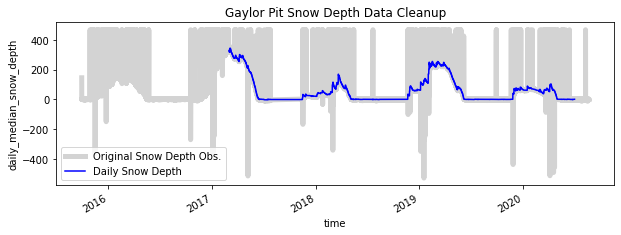

In [11]:
plt.figure(figsize=(10,3))
tuol_ds.depth_cm.plot(linewidth=5, color='lightgrey', label='Original Snow Depth Obs.')
tuol_ds_5min.daily_median_snow_depth.plot(color='b',label='Daily Snow Depth')
plt.title('Gaylor Pit Snow Depth Data Cleanup')
plt.legend();

**Compute difference between GOES Tb and Gaylor Pit Tss**

(GOES Tb - Gaylor Pit Tss) and add it to the dataset

In [12]:
# Orthorectified GOES
tuol_ds_5min['goes_tuol_diff'] = tuol_ds_5min.goes_tb_c - tuol_ds_5min.tss

# Not orthorecitfied, original GOES
tuol_ds_5min['goes_tuol_diff_not_orthorectified'] = tuol_ds_5min.goes_tb_not_orthorectified_c - tuol_ds_5min.tss

**Open the 5-minute GOES-16 ABI Cloud Mask product:**

In [13]:
goes_cloudmask = pd.read_pickle('data/GOES-16_ABI-L2-ACMC_Tuolumne_2017-2020.pkl')
goes_cloudmask = goes_cloudmask.to_xarray()

In [14]:
# convert from UTC to UTC-8
goes_cloudmask.time[0].values

numpy.datetime64('2017-04-18T16:02:22.100000000')

Round the ABI Cloud Mask timestamps to the nearest minute to match these up with the merged GOES and Tuolumne (15-minute interval) data. Add the cloud mask to the cues_ds (**NOTE**: I have only a shorter time period covered by the cloud mask than the rest of the GOES and Tuol data)

In [15]:
_goes_cloudmask = goes_cloudmask.resample(time='15min').mean()
tuol_ds_5min['ABI_Cloud_Mask'] = _goes_cloudmask.BCM
# Fix the cloud mask back to binary (anytime our 15-minute resampling gave us a mixture of clear and clouds, set it to clouds only)
tuol_ds_5min['ABI_Cloud_Mask'][tuol_ds_5min.ABI_Cloud_Mask != 0] = 1

/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Rename the "datetime" index column to just "time" and add an hour of day and month and week field

In [16]:
# create hour of day field
tuol_ds_5min['hour_of_day'] = tuol_ds_5min.time.dt.hour

# create month field
tuol_ds_5min['month'] = tuol_ds_5min.time.dt.month

# create week field
tuol_ds_5min['week'] = tuol_ds_5min.time.dt.week

#### Export this merged dataset

In [17]:
tuol_ds_5min.to_dataframe().to_pickle('data/goes-tuolumne_2017-2020.pkl')

In [18]:
tuol_ds_5min

<xarray.Dataset>
Dimensions:                            (time: 116896)
Coordinates:
  * time                               (time) datetime64[ns] 2017-03-01 ... 2020-06-30T15:45:00
Data variables:
    SlrkW_dwn [kW/m^2]                 (time) float64 nan nan ... 0.156 0.148
    SlrkW_up [kW/m^2]                  (time) float64 nan nan ... 0.863 0.831
    air_temp_c                         (time) float64 -16.46 -15.92 ... 15.88
    depth_cm                           (time) float64 330.5 330.5 ... -1.905
    tss                                (time) float64 -25.96 -24.95 ... 40.36
    goes_tb_c                          (time) float64 -16.39 -16.42 ... 10.95
    goes_rad                           (time) float64 57.33 57.29 ... 92.98
    goes_tb_not_orthorectified_c       (time) float64 -16.39 -16.42 ... 10.92
    goes_rad_not_orthorectified        (time) float64 57.33 57.29 ... 92.93
    daily_median_snow_depth            (time) float64 327.7 322.6 ... 0.7239
    goes_tuol_diff            